In [1]:
import os
from collections import defaultdict
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = "../data"
os.listdir(data_dir)

['origin_destination_bus_201912.csv',
 'bus_stops_wszone.dbf',
 'bus_stops_wszone.shp',
 'OD_bus',
 'train_station_wszone.prj',
 'origin_destination_train_201912-b.csv',
 'train_station_wszone.dbf',
 'subzone_centroid.csv',
 'busstop_from_api.csv',
 'train_station_wszone.cpg',
 'train_station_wszone.shx',
 'bus_stops.dbf',
 'bus_stops.prj',
 'BusStop',
 'subzone_centroid_pos.json',
 '.ipynb_checkpoints',
 'bus_stops.csv',
 'region-2014',
 'train_station_wszone.shp',
 'origin_destination_train_201912.csv',
 'bus_stops_wszone.shx',
 'bus_stops_wszone.prj',
 'bus_stops.cpg',
 'subzone-2014',
 'TrainStation',
 'bus_stops.shx',
 'bus_stops_wszone.cpg',
 'bus_stops.shp']

In [14]:
gdf = gpd.read_file(os.path.join(data_dir, 'train_station_wszone.shp'))
gdf.head()

,OBJECTID_p,STN_NAME,STN_NO,PT_CODE1,index_szon,OBJECTID_s,SUBZONE_NO,SUBZONE_N,SUBZONE_C,CA_IND,...,PLN_AREA_C,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D,X_ADDR,Y_ADDR,SHAPE_Leng,SHAPE_Area,geometry
0,1,EUNOS MRT STATION,EW7,EW7,169,170,5,GEYLANG EAST,GLSZ05,N,...,GL,CENTRAL REGION,CR,58687154BD252A0A,2014-12-05,35237.1681,33246.0587,7028.340071,2.579087e+06,POINT (35782.955 33560.078)
1,2,CHINESE GARDEN MRT STATION,EW25,EW25,146,147,4,LAKESIDE,JESZ04,N,...,JE,WEST REGION,WR,3BBFD45071B70ECF,2014-12-05,16697.0118,35114.9062,8828.633830,3.108023e+06,POINT (16790.747 36056.302)
2,3,KHATIB MRT STATION,NS14,NS14,316,317,8,KHATIB,YSSZ08,N,...,YS,NORTH REGION,NR,DC75517DA31123DB,2014-12-05,27480.6357,44420.6884,4956.145735,1.432913e+06,POINT (27962.311 44352.568)
3,4,KRANJI MRT STATION,NS7,NS7,280,281,2,TURF CLUB,SKSZ02,N,...,SK,NORTH REGION,NR,17459E60C3EEAF30,2014-12-05,20234.6006,44507.1901,7665.676019,3.291406e+06,POINT (20081.697 45214.548)
4,5,REDHILL MRT STATION,EW18,EW18,4,5,3,REDHILL,BMSZ03,N,...,BM,CENTRAL REGION,CR,85D9ABEF0A40678F,2014-12-05,26201.9580,30005.7035,2825.594099,3.874294e+05,POINT (26163.478 30218.820)


In [15]:
len(gdf), gdf.crs

(183,
 {'proj': 'tmerc',
  'lat_0': 1.366666666666667,
  'lon_0': 103.8333333333333,
  'k': 1,
  'x_0': 28001.642,
  'y_0': 38744.572,
  'datum': 'WGS84',
  'units': 'm',
  'no_defs': True})

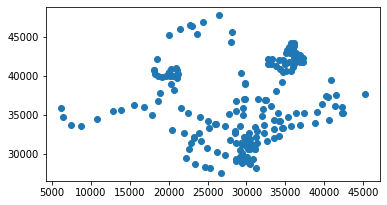

In [16]:
gdf.plot()

In [17]:
train_station_loc = {}
for i,s in zip(gdf["PT_CODE1"].tolist(), gdf["SUBZONE_N"].tolist()):
    train_station_loc[i] = s

In [26]:
df = pd.read_csv(os.path.join(data_dir, "origin_destination_train_201912-b.csv"))
df.head(10)

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,ORIGIN_PT_CODE,DESTINATION_PT_CODE,TOTAL_TRIPS
0,2019-12,WEEKENDS/HOLIDAY,9,TRAIN,EW32,DT24,1
1,2019-12,WEEKDAY,6,TRAIN,BP4,EW31,6
2,2019-12,WEEKENDS/HOLIDAY,7,TRAIN,DT26,CC26,1
3,2019-12,WEEKDAY,7,TRAIN,CC26,DT26,1
4,2019-12,WEEKENDS/HOLIDAY,7,TRAIN,CC26,DT26,1
5,2019-12,WEEKDAY,7,TRAIN,DT26,CC26,2
6,2019-12,WEEKENDS/HOLIDAY,12,TRAIN,NE15,SW5,39
7,2019-12,WEEKDAY,12,TRAIN,NE15,SW5,78
8,2019-12,WEEKDAY,12,TRAIN,SW5,NE15,39
9,2019-12,WEEKENDS/HOLIDAY,12,TRAIN,SW5,NE15,22


In [27]:
df_wday = df[df["DAY_TYPE"]=="WEEKDAY"]
len(df_wday)

426951

In [37]:
def process_an_hour(df_temp, hr):
    flows = defaultdict(int)
    for i in range(len(df_temp)):
        this_row = df_temp.iloc[i]
        o = this_row["ORIGIN_PT_CODE"]
        d = this_row["DESTINATION_PT_CODE"]
        t = this_row["TOTAL_TRIPS"]
        #print(o, d)
        if "-" in o:
            o = o.split("-")[0]
        if "-" in d:
            d = d.split("-")[0]
        o2 = train_station_loc[str(o)]
        d2 = train_station_loc[str(d)]
        flows[(o2, d2)]+=t
    
    flows2 = []
    for k,v in flows.items():
        i,j = k
        drec = {"origin":i, "destination":j, "hour":hr, "flow": v}
        flows2.append(drec)
    df2 = pd.DataFrame.from_dict(flows2)
    #print(df2.head())
    df2 = df2[["origin", "destination", "hour", "flow"]]
    return df2

In [38]:
for hr in range(24):
    temp = df_wday[df_wday["TIME_PER_HOUR"]==hr]
    if len(temp)>0:
        temp2 = process_an_hour(temp, hr)
        print(hr, len(temp), len(temp2))
        fout = os.path.join(data_dir, "OD_train", "OD_201912_weekday_{}.csv".format(str(hr).zfill(2)))
        temp2.to_csv(fout, index_label="ind")
    #break

0 8230 5355
5 12902 8364
6 19595 11021
7 22319 11824
8 22714 11911
9 22392 11843
10 22517 11889
11 22869 11952
12 23429 12076
13 23460 12085
14 23295 12033
15 23465 12091
16 23946 12179
17 24932 12424
18 24864 12381
19 23542 12085
20 22475 11768
21 22189 11611
22 21161 11281
23 16655 9588


In [39]:
df_wend = df[df["DAY_TYPE"]!="WEEKDAY"]
len(df_wend)

372336

In [40]:
for hr in range(24):
    temp = df_wend[df_wend["TIME_PER_HOUR"]==hr]
    if len(temp)>0:
        temp2 = process_an_hour(temp, hr)
        print(hr, len(temp), len(temp2))
        fout = os.path.join(data_dir, "OD_train", "OD_201912_weekend_{}.csv".format(str(hr).zfill(2)))
        temp2.to_csv(fout, index_label="ind")
    #break

0 1865 1364
5 9315 6589
6 16825 10132
7 19164 10947
8 20088 11218
9 20085 11210
10 20356 11248
11 20854 11424
12 21397 11586
13 21441 11548
14 21230 11530
15 21423 11577
16 21826 11688
17 22122 11813
18 21743 11687
19 20832 11432
20 19969 11128
21 19610 10936
22 18424 10479
23 13767 8463
